In [1]:
# author: Xinrui Zhan
# time: 2020/10
# code based on this tutorial: 
# https://medium.com/@BorisAKnyazev/tutorial-on-graph-neural-networks-for-computer-vision-and-beyond-part-1-3d9fada3b80d

In [8]:
# import section
from __future__ import print_function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import pandas as pd
import networkx as nx

In [10]:
import torch
print(torch.__version__)
print(torch.version.cuda)
torch.cuda.is_available()

1.2.0
10.0.130


True

In [5]:
#@copy from https://github.com/bknyaz/examples/blob/master/fc_vs_graph_train.py
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.fc = nn.Linear(1433, 7, bias=False)

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))
            
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #print(data.type())
        data = data.float()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, train_loader):
    model.eval()
    test_loss = 0
    correct_test = 0
    correct_train = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_test += pred.eq(target.view_as(pred)).sum().item()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct_test, len(test_loader.dataset),
            100. * correct_test / len(test_loader.dataset)))
    return (100. * correct_test / len(test_loader.dataset), 100. * correct_train / len(train_loader.dataset))

In [6]:
features = pd.read_csv('cora.content', header=None,delimiter='\t')
features = features.rename(columns={0: 'id', 1434: 'target'}).to_numpy()
X = features[:, 1: -1].astype(int)
y = features[:, -1]
display(X.shape, y.shape)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
display(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

train_x = torch.tensor(X_train) # transform to torch tensor
train_y = torch.from_numpy(y_train)
train_y = train_y.type(torch.long)
train_x = train_x.type(torch.long)

test_x = torch.tensor(X_test) # transform to torch tensor
test_y = torch.from_numpy(y_test)
test_y = test_y.type(torch.long)
test_x = test_x.type(torch.long)

cora_train_dataset = TensorDataset(train_x,train_y)
cora_test_dataset = TensorDataset(test_x,test_y)

(2708, 1433)

(2708,)

(2708,)

In [9]:
model = FNet()
FNet_test_acc = []
FNet_train_acc = []
device = torch.device('cuda')
kwargs = {'num_workers': 1, 'pin_memory': True}
cora_train_dataloader = DataLoader(cora_train_dataset, batch_size=64, shuffle=True, **kwargs)
cora_test_dataloader = DataLoader(cora_test_dataset, batch_size=1000, shuffle=True, **kwargs)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-1)
print('number of trainable parameters: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
for epoch in range(1, 101):
    train(model, device, cora_train_dataloader, optimizer, epoch)
    accs = test(model, device, cora_test_dataloader, cora_train_dataloader)
    FNet_test_acc.append(accs[0])
    FNet_train_acc.append(accs[1])

FNet(
  (fc): Linear(in_features=1433, out_features=7, bias=False)
)
number of trainable parameters: 10031
Train Epoch: 1 [0/2166 (0%)]	Loss: 1.946968
Train Epoch: 1 [640/2166 (29%)]	Loss: 1.940711
Train Epoch: 1 [1280/2166 (59%)]	Loss: 1.947083
Train Epoch: 1 [1920/2166 (88%)]	Loss: 1.957698

Test set: Average loss: 1.9348, Accuracy: 101/542 (19%)

Train Epoch: 2 [0/2166 (0%)]	Loss: 1.933833
Train Epoch: 2 [640/2166 (29%)]	Loss: 1.938287
Train Epoch: 2 [1280/2166 (59%)]	Loss: 1.922541
Train Epoch: 2 [1920/2166 (88%)]	Loss: 1.919498

Test set: Average loss: 1.9185, Accuracy: 163/542 (30%)

Train Epoch: 3 [0/2166 (0%)]	Loss: 1.911649
Train Epoch: 3 [640/2166 (29%)]	Loss: 1.914122
Train Epoch: 3 [1280/2166 (59%)]	Loss: 1.915117
Train Epoch: 3 [1920/2166 (88%)]	Loss: 1.889410

Test set: Average loss: 1.9035, Accuracy: 204/542 (38%)

Train Epoch: 4 [0/2166 (0%)]	Loss: 1.896082
Train Epoch: 4 [640/2166 (29%)]	Loss: 1.900636
Train Epoch: 4 [1280/2166 (59%)]	Loss: 1.899613
Train Epoch: 4 [192


Test set: Average loss: 1.6661, Accuracy: 298/542 (55%)

Train Epoch: 34 [0/2166 (0%)]	Loss: 1.580573
Train Epoch: 34 [640/2166 (29%)]	Loss: 1.600926
Train Epoch: 34 [1280/2166 (59%)]	Loss: 1.626996
Train Epoch: 34 [1920/2166 (88%)]	Loss: 1.629581

Test set: Average loss: 1.6620, Accuracy: 300/542 (55%)

Train Epoch: 35 [0/2166 (0%)]	Loss: 1.620896
Train Epoch: 35 [640/2166 (29%)]	Loss: 1.596379
Train Epoch: 35 [1280/2166 (59%)]	Loss: 1.685265
Train Epoch: 35 [1920/2166 (88%)]	Loss: 1.594895

Test set: Average loss: 1.6580, Accuracy: 300/542 (55%)

Train Epoch: 36 [0/2166 (0%)]	Loss: 1.660198
Train Epoch: 36 [640/2166 (29%)]	Loss: 1.566050
Train Epoch: 36 [1280/2166 (59%)]	Loss: 1.606051
Train Epoch: 36 [1920/2166 (88%)]	Loss: 1.638267

Test set: Average loss: 1.6541, Accuracy: 303/542 (56%)

Train Epoch: 37 [0/2166 (0%)]	Loss: 1.623767
Train Epoch: 37 [640/2166 (29%)]	Loss: 1.621958
Train Epoch: 37 [1280/2166 (59%)]	Loss: 1.663976
Train Epoch: 37 [1920/2166 (88%)]	Loss: 1.589161

Tes


Test set: Average loss: 1.5744, Accuracy: 318/542 (59%)

Train Epoch: 67 [0/2166 (0%)]	Loss: 1.575848
Train Epoch: 67 [640/2166 (29%)]	Loss: 1.583359
Train Epoch: 67 [1280/2166 (59%)]	Loss: 1.505091
Train Epoch: 67 [1920/2166 (88%)]	Loss: 1.477651

Test set: Average loss: 1.5725, Accuracy: 319/542 (59%)

Train Epoch: 68 [0/2166 (0%)]	Loss: 1.494586
Train Epoch: 68 [640/2166 (29%)]	Loss: 1.517061
Train Epoch: 68 [1280/2166 (59%)]	Loss: 1.536996
Train Epoch: 68 [1920/2166 (88%)]	Loss: 1.481224

Test set: Average loss: 1.5707, Accuracy: 319/542 (59%)

Train Epoch: 69 [0/2166 (0%)]	Loss: 1.509212
Train Epoch: 69 [640/2166 (29%)]	Loss: 1.522695
Train Epoch: 69 [1280/2166 (59%)]	Loss: 1.555849
Train Epoch: 69 [1920/2166 (88%)]	Loss: 1.545057

Test set: Average loss: 1.5689, Accuracy: 319/542 (59%)

Train Epoch: 70 [0/2166 (0%)]	Loss: 1.534770
Train Epoch: 70 [640/2166 (29%)]	Loss: 1.562555
Train Epoch: 70 [1280/2166 (59%)]	Loss: 1.575869
Train Epoch: 70 [1920/2166 (88%)]	Loss: 1.504752

Tes


Test set: Average loss: 1.5302, Accuracy: 333/542 (61%)

Train Epoch: 100 [0/2166 (0%)]	Loss: 1.457274
Train Epoch: 100 [640/2166 (29%)]	Loss: 1.513364
Train Epoch: 100 [1280/2166 (59%)]	Loss: 1.533000
Train Epoch: 100 [1920/2166 (88%)]	Loss: 1.421636

Test set: Average loss: 1.5293, Accuracy: 332/542 (61%)



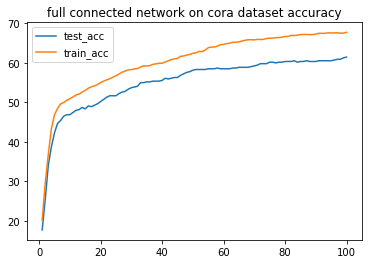

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, 101), FNet_test_acc, label = "test_acc")
plt.plot(range(1, 101), FNet_train_acc, label = "train_acc")
plt.legend()
plt.title("full connected network on cora dataset accuracy")
plt.show()

## GNN

In [154]:
class one_layer_GraphNet(nn.Module):
    def __init__(self, A, X, pred_edge=False):
        super(one_layer_GraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = 1433
        self.fc = nn.Linear(N, 7, bias=False)
        # precompute adjacency matrix before training
        self.A = A
        self.register_buffer('X', X.float())

    def forward(self, x, batch_idx, batch_size=64):
        B = x.size(0)
        # average all neighboors
        #print(x.shape)
        A = torch.from_numpy(self.A[batch_idx*batch_size:batch_idx*batch_size+64]).float()
        A = A.float()
        A = A.to(device)
        #print(A.shape)
        #print(self.X.shape)
        #print(A.dtype, self.X.dtype, x.dtype)
        avg_neighbor_features = torch.matmul(A, self.X)
        x = x.float()
        return self.fc(avg_neighbor_features)
    
def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, batch_idx)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, batch_idx)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
    '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [155]:
G = nx.read_edgelist("cora.cites") #read
display(G.number_of_nodes())

# calculate the adjance matrix and normalize it
A = nx.adjacency_matrix(G).todense()
#A = torch.from_numpy(A).float()
A = np.asarray(A).reshape(2708, 2708)

X = features[:, 1: -1].astype(int)
X = torch.from_numpy(X).type(torch.long)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])


2708

  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs

In [156]:
GNN = one_layer_GraphNet(A,X)
GNN_test_acc = []
GNN.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-1)
print('number of trainable parameters: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
full_x = torch.tensor(X) # transform to torch tensor
full_y = torch.from_numpy(y)
full_y = full_y.type(torch.long)
full_x = full_x.type(torch.long)

cora_full_dataset = TensorDataset(full_x,full_y)
cora_full_dataloader = DataLoader(cora_full_dataset, batch_size=64, shuffle=True, **kwargs)
for epoch in range(1, 101):
    train(GNN, device, cora_full_dataloader, optimizer)
    accs = test(GNN, device, cora_full_dataloader)
    GNN_test_acc.append(accs)

FNet(
  (fc): Linear(in_features=1433, out_features=7, bias=False)
)
number of trainable parameters: 10031


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Train Epoch: 1 [0/2708 (0%)]	Loss: 1.931578
Train Epoch: 1 [640/2708 (23%)]	Loss: 1.997056
Train Epoch: 1 [1280/2708 (47%)]	Loss: 1.939596
Train Epoch: 1 [1920/2708 (70%)]	Loss: 1.980574
Train Epoch: 1 [2560/2708 (93%)]	Loss: 1.979667

Test set: Average loss: 1.9655, Accuracy: 334/2708 (12%)

Train Epoch: 2 [0/2708 (0%)]	Loss: 2.048614
Train Epoch: 2 [640/2708 (23%)]	Loss: 1.961201
Train Epoch: 2 [1280/2708 (47%)]	Loss: 1.997558
Train Epoch: 2 [1920/2708 (70%)]	Loss: 1.980626
Train Epoch: 2 [2560/2708 (93%)]	Loss: 1.973686

Test set: Average loss: 1.9728, Accuracy: 306/2708 (11%)

Train Epoch: 3 [0/2708 (0%)]	Loss: 1.959840
Train Epoch: 3 [640/2708 (23%)]	Loss: 1.931158
Train Epoch: 3 [1280/2708 (47%)]	Loss: 2.000509
Train Epoch: 3 [1920/2708 (70%)]	Loss: 1.973112
Train Epoch: 3 [2560/2708 (93%)]	Loss: 1.971459

Test set: Average loss: 1.9710, Accuracy: 324/2708 (12%)

Train Epoch: 4 [0/2708 (0%)]	Loss: 1.991351
Train Epoch: 4 [640/2708 (23%)]	Loss: 1.978229
Train Epoch: 4 [1280/2708 (


Test set: Average loss: 1.9743, Accuracy: 323/2708 (12%)

Train Epoch: 29 [0/2708 (0%)]	Loss: 2.012794
Train Epoch: 29 [640/2708 (23%)]	Loss: 1.968732
Train Epoch: 29 [1280/2708 (47%)]	Loss: 1.970714
Train Epoch: 29 [1920/2708 (70%)]	Loss: 1.962744
Train Epoch: 29 [2560/2708 (93%)]	Loss: 1.979801

Test set: Average loss: 1.9722, Accuracy: 343/2708 (13%)

Train Epoch: 30 [0/2708 (0%)]	Loss: 2.090175
Train Epoch: 30 [640/2708 (23%)]	Loss: 1.960992
Train Epoch: 30 [1280/2708 (47%)]	Loss: 1.997814
Train Epoch: 30 [1920/2708 (70%)]	Loss: 1.948100
Train Epoch: 30 [2560/2708 (93%)]	Loss: 1.957120

Test set: Average loss: 1.9747, Accuracy: 304/2708 (11%)

Train Epoch: 31 [0/2708 (0%)]	Loss: 2.027785
Train Epoch: 31 [640/2708 (23%)]	Loss: 1.977527
Train Epoch: 31 [1280/2708 (47%)]	Loss: 1.945505
Train Epoch: 31 [1920/2708 (70%)]	Loss: 1.980674
Train Epoch: 31 [2560/2708 (93%)]	Loss: 1.958087

Test set: Average loss: 1.9761, Accuracy: 334/2708 (12%)

Train Epoch: 32 [0/2708 (0%)]	Loss: 2.002501

Train Epoch: 56 [1920/2708 (70%)]	Loss: 1.966723
Train Epoch: 56 [2560/2708 (93%)]	Loss: 1.960735

Test set: Average loss: 1.9723, Accuracy: 311/2708 (11%)

Train Epoch: 57 [0/2708 (0%)]	Loss: 2.085795
Train Epoch: 57 [640/2708 (23%)]	Loss: 1.970841
Train Epoch: 57 [1280/2708 (47%)]	Loss: 1.959633
Train Epoch: 57 [1920/2708 (70%)]	Loss: 1.960894
Train Epoch: 57 [2560/2708 (93%)]	Loss: 1.985427

Test set: Average loss: 1.9728, Accuracy: 317/2708 (12%)

Train Epoch: 58 [0/2708 (0%)]	Loss: 2.067924
Train Epoch: 58 [640/2708 (23%)]	Loss: 1.976116
Train Epoch: 58 [1280/2708 (47%)]	Loss: 1.954110
Train Epoch: 58 [1920/2708 (70%)]	Loss: 1.955208
Train Epoch: 58 [2560/2708 (93%)]	Loss: 1.953291

Test set: Average loss: 1.9731, Accuracy: 314/2708 (12%)

Train Epoch: 59 [0/2708 (0%)]	Loss: 2.030685
Train Epoch: 59 [640/2708 (23%)]	Loss: 1.995131
Train Epoch: 59 [1280/2708 (47%)]	Loss: 1.994605
Train Epoch: 59 [1920/2708 (70%)]	Loss: 1.978620
Train Epoch: 59 [2560/2708 (93%)]	Loss: 1.956326

Test

Train Epoch: 84 [0/2708 (0%)]	Loss: 1.945428
Train Epoch: 84 [640/2708 (23%)]	Loss: 1.968040
Train Epoch: 84 [1280/2708 (47%)]	Loss: 1.969968
Train Epoch: 84 [1920/2708 (70%)]	Loss: 1.979414
Train Epoch: 84 [2560/2708 (93%)]	Loss: 1.938646

Test set: Average loss: 1.9721, Accuracy: 351/2708 (13%)

Train Epoch: 85 [0/2708 (0%)]	Loss: 2.016450
Train Epoch: 85 [640/2708 (23%)]	Loss: 1.953452
Train Epoch: 85 [1280/2708 (47%)]	Loss: 2.006234
Train Epoch: 85 [1920/2708 (70%)]	Loss: 1.997195
Train Epoch: 85 [2560/2708 (93%)]	Loss: 1.946887

Test set: Average loss: 1.9779, Accuracy: 302/2708 (11%)

Train Epoch: 86 [0/2708 (0%)]	Loss: 1.998552
Train Epoch: 86 [640/2708 (23%)]	Loss: 1.948653
Train Epoch: 86 [1280/2708 (47%)]	Loss: 2.007052
Train Epoch: 86 [1920/2708 (70%)]	Loss: 1.957553
Train Epoch: 86 [2560/2708 (93%)]	Loss: 1.960881

Test set: Average loss: 1.9702, Accuracy: 338/2708 (12%)

Train Epoch: 87 [0/2708 (0%)]	Loss: 2.015155
Train Epoch: 87 [640/2708 (23%)]	Loss: 1.946390
Train Epoc

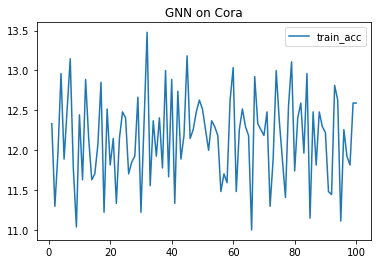

In [157]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), GNN_test_acc, label = "train_acc")
plt.legend()
plt.title("GNN on Cora")
plt.show()